In [1]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt

In [2]:
conn = sqlite3.connect("OneMillion/million_post_corpus/corpus.sqlite3", isolation_level=None,
                       detect_types=sqlite3.PARSE_COLNAMES)

In [3]:

conn = sqlite3.connect("OneMillion/million_post_corpus/corpus.sqlite3", isolation_level=None,
                       detect_types=sqlite3.PARSE_COLNAMES)
db_df = pd.read_sql_query("SELECT ID_User, Body from Posts WHERE ID_User in (SELECT ID_User from Posts GROUP BY ID_User HAVING count(*) >= 250)", conn)
db_df.to_csv('ompdatabase.csv', index=False)

In [4]:
df = pd.read_csv('ompdatabase.csv')
col = ['ID_User', 'Body']
df = df[col]

In [5]:
df.shape

(366459, 2)

In [6]:
df.dropna(subset={'Body'}, inplace=True)

In [7]:
df.shape

(350194, 2)

In [8]:
df.head()

,ID_User,Body
0,9036,per RSS feed
1,12071,"ich kann keinen hinweis finden, wo man sich hi..."
2,27465,Sehr geehrte Community oder cmb!\r\n\r\nBekomm...
3,27465,"@ sni, danke für die Antwort! Habe das ehrlich..."
4,12318,"In einer Welt, in der man jede endliche Zahl v..."


In [9]:
from io import StringIO

df['short_id'] = df['ID_User'].factorize()[0]
category_id_df = df[['ID_User', 'short_id']].drop_duplicates().sort_values('short_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['short_id', 'ID_User']].values)
df.head(20)

,ID_User,Body,short_id
0,9036,per RSS feed,0
1,12071,"ich kann keinen hinweis finden, wo man sich hi...",1
2,27465,Sehr geehrte Community oder cmb!\r\n\r\nBekomm...,2
3,27465,"@ sni, danke für die Antwort! Habe das ehrlich...",2
4,12318,"In einer Welt, in der man jede endliche Zahl v...",3
5,3159,...und auch die neue firma personalisierte mai...,4
6,21046,Wirklich? darf man das jetzt wieder?\r\n\r\nht...,5
7,16722,"Ja, diese Frage ist in letzter Zeit häufiger z...",6
8,3159,...posts bzw. Konto wäre eine gute Erweiterung...,4
9,25974,Danke für's posten. Das ist ein Ausschliessung...,7


In [10]:
df_minLength = df[df['Body'].apply(len) > 500]
df_minLength['ID_User'].value_counts()

5854     468
14587    387
22876    374
25987    341
26866    339
        ... 
20330      1
27357      1
19691      1
2210       1
28480      1
Name: ID_User, Length: 765, dtype: int64

Nur verbleibende User mit mehr als 250 Posts

In [11]:
df2 = df_minLength.groupby('ID_User').filter(lambda x : len(x)>250)

In [12]:
df2['ID_User'].value_counts()

5854     468
14587    387
22876    374
25987    341
26866    339
15886    293
18446    292
12471    288
3105     287
30344    284
10627    276
20349    273
Name: ID_User, dtype: int64

In [13]:
df2.drop(['ID_User'], axis=1)

,Body,short_id
733,"Sie haben die Siegesfeier und ein neues ""rotes...",187
744,Wenn die beiden Seiten doch so verschieden sin...,187
771,"Wärest du im richtigen System, dann würdest di...",187
838,"Verkomplizierungen, und trotzdem ist das das P...",222
839,"Was Krankheit oder nur Besonderheit ist, ist l...",222
...,...,...
365194,"""Das durchschnittliche Nettofinanzvermögen (oh...",85
365363,"""Das heißt, es werden alle Dublin-Fälle, also ...",364
365370,"Die ""Dublin"" Fälle, müssten eigentlich alle As...",779
366126,"""Parlamentarische Mehrheit"" sagt im österreich...",222


In [14]:
df2['short_id'].value_counts()

298    468
408    387
222    374
364    341
187    339
85     293
317    292
779    288
567    287
312    284
625    276
563    273
Name: short_id, dtype: int64

Code von https://github.com/faizann24/Authorship-Attribution angepasst

In [15]:
# Basic libraries
import io
import os
import sys
import argparse
import numpy as np
from os import walk

# Scikit learn stuff
from sklearn.metrics import *
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

ARTICLES_PER_AUTHOR = 250
AUTHORS = 6
#IDS = [298,408,222,364,187,85]
IDS = [317,779,567,312,625,563]


def calculate_top5accuracy(calc_labels, prediction_probs):
	"""
	Takes as input labels and prediction probabilities and calculates the top-5 accuracy of the model
	"""
	acc = []
	for j in range(0, len(prediction_probs)):
		pre_probs = prediction_probs[j]
		pre_probs_indices = np.argsort(-pre_probs)[:5]
		if calc_labels[j] in pre_probs_indices:
			acc.append(1)
		else:
			acc.append(0)

	return round(((acc.count(1) * 100) / len(acc)), 2)

author_array = []
for x in range(AUTHORS):
    author = df2[df2['short_id'] == IDS[x]]
    author = author.reset_index()
    author = author.drop(['index'], axis=1)
    author = author.drop(['short_id'], axis=1)
    
    author_array.append(author)


authorArticles = []
labels = []
authorId = 0

for author in author_array:
    for x in range(ARTICLES_PER_AUTHOR):
        authorArticles.append(author.loc[x, "Body"])
        labels.append(authorId)
    authorId = authorId+1

print("\nTraining and testing...")
# Train and get results
accuracies, precisions, recalls, fscores, top5accuracies = [], [], [], [], []
for i in range(5):
	# Train and test 5 different times and average the results

	# Split data into training and testing
	trainData, testData, trainLabels, testLabels = train_test_split(authorArticles, labels, test_size=0.2)

	# Convert raw corpus into tfidf scores
	vectorizer = TfidfVectorizer(min_df=15)
	vectorizer.fit(trainData)
	trainData = vectorizer.transform(trainData).toarray()
	testData = vectorizer.transform(testData).toarray()

	# Create a classifier instance
	classifier = RandomForestClassifier(n_estimators=100)

	# Train classifier
	classifier.fit(trainData, trainLabels)

	# Get test predictions
	testPredictions = classifier.predict(testData)
	testPredictionsProbs = classifier.predict_proba(testData)
	testTopFiveAccuracy = calculate_top5accuracy(testLabels, testPredictionsProbs)

	# Calculate metrics
	accuracy = round(accuracy_score(testLabels, testPredictions) * 100, 2)
	precision = round(precision_score(testLabels, testPredictions, average='macro') * 100, 2)
	recall = round(recall_score(testLabels, testPredictions, average='macro') * 100, 2)
	fscore = round(f1_score(testLabels, testPredictions, average='macro') * 100, 2)
	confusionMatrix = confusion_matrix(testLabels, testPredictions)

	# Store metrics in lists
	accuracies.append(accuracy)
	precisions.append(precision)
	recalls.append(recall)
	fscores.append(fscore)
	top5accuracies.append(testTopFiveAccuracy)

print("Top-5 Test Accuracy: %.2f\nTest Accuracy: %.2f\nTest Precision: %.2f\nTest Recall: %.2f\nTest Fscore: %.2f\n" % (
															np.mean(top5accuracies), np.mean(accuracies), np.mean(precisions), np.mean(recalls), np.mean(fscores)))




Training and testing...
Top-5 Test Accuracy: 99.67
Test Accuracy: 84.40
Test Precision: 84.44
Test Recall: 84.20
Test Fscore: 84.12



[[34  1  3  0  5  3]
 [ 2 45  1  0  0  4]
 [ 2  2 38  1  5  0]
 [ 0  0  0 62  0  2]
 [ 4  2  1  0 35  1]
 [ 0  1  2  0  0 44]]


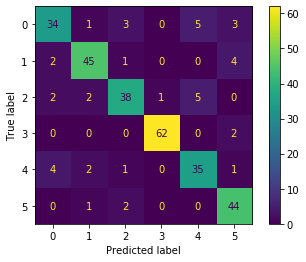

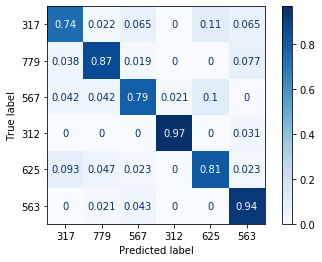

In [16]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

matrix = confusion_matrix(testLabels, testPredictions)
print(matrix)


# disp = plot_confusion_matrix(classifier, testData, testLabels,
# display_labels=[0,1,2,3,4], cmap=plt.cm.Blues, normalize='true')
# DEPRECATED

ConfusionMatrixDisplay.from_estimator(classifier, testData, testLabels)
#ConfusionMatrixDisplay.from_predictions(testLabels, testPredictions)

matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

disp = ConfusionMatrixDisplay(matrix,display_labels=IDS)
disp.plot(cmap=plt.cm.Blues)
plt.show()